# Samuel Watkins, 3032132676

# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley 2018

Due Tuesday 2pm, Feb 20, 2018

# 1) Monty: The Python Siri

Let's make a Siri-like program (call it Monty!) with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify (or, e.g., Google Speech https://cloud.google.com/speech/) to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [156]:
import pyaudio
import smtplib
import os
import my_credentials as creds
import wave
import houndify
import numpy as np

import requests

from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email import encoders
from email.utils import COMMASPACE, formatdate

In [179]:
# Houndify listener, taken from Houndify SDK sample_wave.py
class MyListener(houndify.HoundListener):
    def onPartialTranscript(self, transcript):
        return
    def onFinalResponse(self, response):
        textString=response['AllResults'][0]['WrittenResponseLong']
        print(f"Monty heard: \"{textString}\"")
        return
    def onError(self, err):
        print("Error: " + str(err))

# taken from lecture, changed print outputs
def MontyListens(RECORD_SECONDS=5):
    # can change number of seconds to record by specifying RECORD_SECONDS
    # set up pyaudio for recording
    p = pyaudio.PyAudio()
    
    chunk = 1024
    FORMAT = p.get_format_from_width(2) # Houndify requires a sample width of 2
    CHANNELS = 1
    RATE = 16000
    WAVE_OUTPUT_FILENAME = "MontySnippet.wav"
    
    stream = p.open(format = FORMAT,
        channels = CHANNELS,
        rate = RATE,
        input = True,
        frames_per_buffer = chunk)
    print("Monty is listening!")
    
    # record data
    all = []
    for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
        data = stream.read(chunk)
        all.append(data)
    print("Monty is thinking...")
    # stop listening and close pyaudio
    stream.close()
    p.terminate()
    
    # with data recorded, create a .wav file
    data = b"".join(all)
    wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()
    
    # return the .wav filename to open using Houndify
    return WAVE_OUTPUT_FILENAME

def MontyConverts(AUDIO_FILE,CLIENT_ID,CLIENT_KEY):
    # convert speech to text via Houndify
    # AUDIO_FILE = filename of the .wav file to listen to 
    # CLIENT_ID = Houndify API Client ID
    # CLIENT_KEY = Houndify API Client Key
    BUFFER_SIZE = 512
    
    # open .wav file, make sure it has correct attributes
    audio = wave.open(AUDIO_FILE)
    
    if audio.getsampwidth() != 2:
        print("%s: wrong sample width (must be 16-bit)" % AUDIO_FILE)
        audio.close()
        return
    if audio.getframerate() != 8000 and audio.getframerate() != 16000:
        print("%s: unsupported sampling frequency (must be either 8 or 16 khz)" % AUDIO_FILE)
        audio.close()
        return
    if audio.getnchannels() != 1:
        print("%s: must be single channel (mono)" % AUDIO_FILE)
        audio.close()
        return
    
    # set up client
    client = houndify.StreamingHoundClient(CLIENT_ID, CLIENT_KEY, "test_user")
    client.setLocation(37.388309, -121.973968)
    
    # listen to the .wav file
    client.setSampleRate(audio.getframerate())
    client.start(MyListener())

    while True:
        samples = audio.readframes(BUFFER_SIZE)
        if len(samples) == 0: 
            break
        if client.fill(samples): 
            break

    audio.close()
    result = client.finish() # returns either final response or error
    return result['AllResults'][0]['WrittenResponseLong'].lower() # return the response, all lowercase

# function that figures out what the command is
def MontyThinks(textResult):
    # textResult = string of Houndify output
    # returns 0 if an email, 1 if a math problem, 2 if a joke, and -1 if Monty doesn't know what to do
    
    textArray = np.array(textResult.split(" ")) # split into an array using space as delimiter
    
    # check for the key word
    if any(textArray=="email"):
        print("Monty is sending your email...")
        return 0
    elif any(textArray=="calculate"):
        print("Monty is calculating...")
        return 1
    elif any(textArray=="joke"):
        print("Monty is thinking of a joke...")
        return 2
    else:
        print("Monty doesn't know what to do... Sorry!")
        return -1
        

# from the email_example.py code, removed file attachment ability, SMTP -> SMTP_SSL
def MontyEmails(sender, pwd, to, text):
    # sender = email of sender
    # pwd = password of sender (if using 2-step authentication, create an app password)
    # to = email of recipient
    # text = what Monty heard
    
    textArray = np.array(text.split(" ")) # split into an array using space as delimiter
    
    # find where the subject and body start 
    subjectIndex = np.where(textArray=="subject")[0]
    bodyIndex = np.where(textArray=="body")[0]
    
    if not bodyIndex and not subjectIndex: # neither body or subject was said
        bodyStr = ["(No Body)"]
        subjectStr = ["(No Subject)"]
    elif not bodyIndex: # subect was said, body was not
        subjectStr = textArray[subjectIndex[0]+1:]
        bodyStr = ["(No Body)"] # if body was not said
    elif not subjectIndex:
        subjectStr = ["(No Subject)"] # if subject was not said
        bodyStr = textArray[bodyIndex[0]+1:]
    else: # both subject and body were said
        # check if body was said first or if subject was said first (assuming the first instance of the word)
        if subjectIndex[0] < bodyIndex[0]:
            subjectStr = textArray[subjectIndex[0]+1:bodyIndex[0]]
            bodyStr = textArray[bodyIndex[0]+1:]
        else:
            subjectStr = textArray[subjectIndex[0]+1:]
            bodyStr = textArray[bodyIndex[0]+1:subjectIndex[0]]
    
    # if the last word of a string is and, then don't send that part
    if len(subjectStr)>1 and subjectStr[-1]=="and":
        subjectStr = subjectStr[:-1]
    if len(bodyStr)>1 and bodyStr[-1]=="and":
        bodyStr = bodyStr[-1]
    
    # join the subject and body into one string, delimited by spaces
    subject = " ".join(subjectStr)
    body = " ".join(bodyStr)
    
    # create email message
    msg = MIMEMultipart()
    msg["From"] = sender
    msg["To"] = COMMASPACE.join(to)
    msg["Date"] = formatdate(localtime=True)
    msg["Subject"] = subject
    msg.attach(MIMEText(body))
    
    # open mail server, login, send message, close server
    mailServer = smtplib.SMTP_SSL("smtp.gmail.com", creds.GMAIL_SMTP_PORT)
    mailServer.login(sender, pwd)
    mailServer.sendmail(sender, to, msg.as_string())
    mailServer.close()
    
    print(f"Monty sent an email to {COMMASPACE.join(to)} with subject \"{subject}\" and body \"{body}\"")
    return msg
    
# code for calculating an equation that is said
def MontyCalculates(text):
    # text = what Monty heard
    # if we are dividing, we take out the space between divided by, so that it stays as one word
    text=text.replace("divided by","dividedby")
    text=text.replace("multiplied by","multipliedby") # same for multiplied by
    text=text.replace(",","") # Houndify puts commas in large numbers, take them out
    
    textArray = np.array(text.split(" ")) # split into an array using space as delimiter
    
    # define operations and numbers in word form
    operations = np.array(["plus","minus","times","dividedby","multipliedby"])
    numbers = np.array(["zero","one","two","three","four","five","six","seven","eight","nine",
                   "ten","eleven","twelve","thirteen","fourteen","fifteen","sixteen",
                   "seventeen","eighteen","ninteen","twenty"])
    
    # where the calculate word starts
    eqnIndex = np.where(textArray=="calculate")[0][0]
    
    # figure out what the first word is, so we can know not to look at previous words
    firstWord = textArray[eqnIndex+1]
    
    # check if the first word is a number (and if it's the word for the number, or if it's already a number)
    if firstWord in numbers:
        num = np.where(numbers==firstWord)[0][0] # which number it is
        calcResult = num # first word -> this is the start of the calculation
        lastWord = firstWord # save the first word as lastWord
    elif any(char.isdigit() for char in firstWord):
        num = float(firstWord) # if it is already in number form, convert to float
        calcResult = num # first word -> this is the start of the calculation
        lastWord = firstWord # save the first word as lastWord
    elif word in operations:
        print(f"Monty doesn't like when you start an equation with an operator, skipping {word}")
        lastWord = "plus" # placeholder values
        calcResult = 0
    else:
        print(f"Monty doesn't know what you mean by {word}, skipping {word}")
        lastWord = "plus" # placeholder values
        calcResult = 0
        
    # loop over every next word in the calculation, carrying out the specified commands in order
    for word in textArray[eqnIndex+2:]:
        # check if the word is a number (and if it's the word for the number, or if it's already a number)
        if word in numbers: 
            num = np.where(numbers==word)[0][0]
            if lastWord in operations: # do the operation specified by the last word
                if lastWord == "plus":
                    calcResult+=num
                elif lastWord == "minus":
                    calcResult-=num
                elif lastWord == "times" or lastWord == "multipliedby":
                    calcResult*=num
                else:
                    calcResult/=num
            elif lastWord in numbers or any(char.isdigit() for char in lastWord):
                # assume there is a plus if there are two numbers in a row 
                # (this is used when doing subtraction, since Houndify gives "1 minus 1" as "one -1")
                calcResult+=num
            lastWord = word
        elif any(char.isdigit() for char in word):
            num = float(word)
            if lastWord in operations: # do the operation specified by the last word
                if lastWord == "plus":
                    calcResult+=num
                elif lastWord == "minus":
                    calcResult-=num
                elif lastWord == "times" or lastWord == "multipliedby":
                    calcResult*=num
                else:
                    calcResult/=num
            elif lastWord in numbers or any(char.isdigit() for char in lastWord):
                # assume there is a plus if there are two numbers in a row
                # (this is used when doing subtraction, since Houndify gives "1 minus 1" as "one -1")
                calcResult+=num
            lastWord = word
        elif word in operations:
            lastWord = word
        else:
            print(f"Monty doesn't know what you mean by {word}, skipping {word}")
                
    print(f"Monty calculated the answer to be {calcResult}")
    return calcResult

# Monty tells a joke by searching an online joke database
def MontyTellsAJoke():
    # Monty requests a joke from icanhazdadjoke.com
    url = "https://icanhazdadjoke.com/"
    headers = {"Accept": "application/json"}
    response = requests.get(url, headers=headers)
    print(response.json()["joke"])
    return response.json()["joke"]

    

In [183]:
# Load up the Gmail user, pass, and Houndify credentials
GMAIL_USER = creds.GMAIL_USERNAME
GMAIL_PASS = creds.GMAIL_PASSWORD
CLIENT_ID = creds.HOUNDIFY_CLIENT_ID
CLIENT_KEY = creds.HOUNDIFY_CLIENT_KEY

# Boot up Monty, listen to the user (default is for ten seconds)
wavFilename = MontyListens(RECORD_SECONDS=10)

# Monty sends the .wav file to Houndify, returns what was said as a string
textResult = MontyConverts(wavFilename,CLIENT_ID,CLIENT_KEY)

# textResult = "Monte email subject body"

# Monty determines what you want him to do
resultCode = MontyThinks(textResult)

if resultCode == 0:
    # Monty will send you an email
    msg = MontyEmails(sender=GMAIL_USER, 
                      pwd=GMAIL_PASS, 
                      to=[GMAIL_USER,],   # include an extra comma in the "to" list to account for the COMMASPACE.join(to)
                      text=textResult)
elif resultCode == 1:
    # Monty will calculate the math problem
    calcResult = MontyCalculates(text=textResult)
elif resultCode ==2:
    # Monty will tell a joke
    joke = MontyTellsAJoke()




Monty is sending your email...
Monty sent an email to samwatkinss@gmail.com with subject "" and body ""


# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/spring2018/ay250class13410/resources -> Homeworks -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [546]:
%matplotlib inline
import numpy as np
import aifc
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

In [547]:
# get all files
files = glob("sound_files/*.aif")

# the base frequencies for each musical note
MusicNoteFreqs = np.array([16.35,17.32,18.35,19.45,20.60,21.83,23.12,24.50,25.96,27.50,29.14,30.87])
# corresponding music note labels
MusicNoteLabels = np.array(["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"])

nOctaves = 9 # octaves range from 0 to 8 for each of these musical notes

# create a dataframe to store the data in
df = pd.DataFrame(files,columns=["Filename"])
df.sort_values(by="Filename")

fileList = [] # store the music notes detected for each file here

for soundFile in files:
    # open the sound file
    with aifc.open(soundFile) as af:
        nFrames = af.getnframes() # get number of frames
        sampleRate = af.getframerate() # get samplerate
        strSig = af.readframes(nFrames) # given the number of frames, read them out
        signal = np.fromstring(strSig, dtype=np.int32).byteswap() # convert to np array for analysis

    # periodogram amounts to taking the magnitude of the fft, squaring it, and taking only the positive frequencies
    # this gives us the (one-sided) power spectral density
    freqs,pSignal = periodogram(signal,fs=sampleRate)
    
    # take all of the peaks that are greater than 10% of the maximum peak to look for music notes
    peaks = freqs[pSignal/max(pSignal)>0.1]

    frequencyList=[] # store the frequencies for this file here
    
    # loop over all music notes and all octaves, checking if each music note if in the file
    for iOctave in range(0,nOctaves):
        for iFreq in range(0,len(MusicNoteFreqs)):
            #calculate the frequency for this music note as this octave
            freqOctave = MusicNoteFreqs[iFreq]*2**(iOctave)
            # check if any of the peaks are within 1 Hz of a music note
            if any(abs(peaks-freqOctave)<1.0):
                # check if a peak at a lower octave already exists for this music note
                # if it does, then don't record this peak, as it's a harmonic
                if not any(MusicNoteLabels[iFreq] in note for note in frequencyList):
                    frequencyList.append(MusicNoteLabels[iFreq]+str(iOctave))
    
    # store the detected music notes for this file here
    fileList.append(frequencyList)

# add the music notes to our dataframe
df["Notes"] = fileList

### Here are the music notes found in each file:

In [548]:
df.sort_values(by=["Filename"])

,Filename,Notes
6,sound_files/1.aif,"[C4, D4, G4]"
7,sound_files/10.aif,"[C2, G3]"
12,sound_files/11.aif,[E2]
4,sound_files/12.aif,"[C2, G3]"
8,sound_files/2.aif,"[F3, C5]"
13,sound_files/3.aif,[E6]
10,sound_files/4.aif,"[C4, G5]"
3,sound_files/5.aif,"[G2, D3, B4]"
5,sound_files/6.aif,"[C5, G6]"
14,sound_files/7.aif,"[D5, A6]"


### Some Example Plots of My Methodology

The idea of my code is to: 

1. Take the PSD of each file. 
2. Identify the frequency peaks as any peak that has an amplitude that is greater than 10% of the maximum value. 
3. With this list of peaks known, compare each peak to the known music note frequencies. 

If any peak is with 1 Hz of a music note, then I say that that music note is in the data. I only record the lowest octave that exists in the data, as any higher octave is a harmonic of the base note.

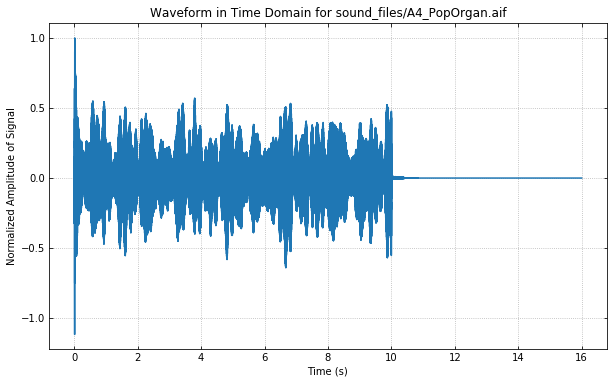

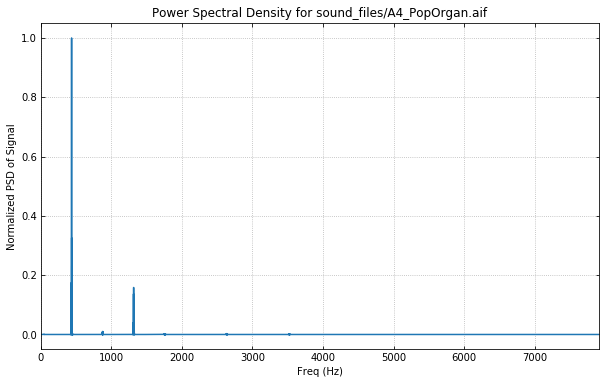

In [549]:
# Let's look at the last file that was processed

# plot the waveform in time domain
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(signal)/sampleRate,1/sampleRate),signal/max(signal))
plt.ylabel("Normalized Amplitude of Signal")
plt.xlabel("Time (s)")
plt.tick_params(which="both",direction="in",right="on",top="on")
plt.grid(linestyle="dotted")
plt.title(f"Waveform in Time Domain for {soundFile}");

# plot the PSD of the waveform
plt.figure(figsize=(10,6))
plt.plot(freqs,pSignal/max(pSignal))
plt.ylabel("Normalized PSD of Signal")
plt.xlabel("Freq (Hz)")
plt.xlim((0,MusicNoteFreqs[-1]*2**(nOctaves-1))) # let's just look at the PSD in the region of the music notes
plt.tick_params(which="both",direction="in",right="on",top="on")
plt.grid(linestyle="dotted")
plt.title(f"Power Spectral Density for {soundFile}");

Note the two peaks, one at ~440.00 Hz (A4) and the other at ~1318.51 Hz (E6). As both of these peaks have normalized amplitudes that are above 0.1, they were both detected.

Let's look at another data file, just to see another example.

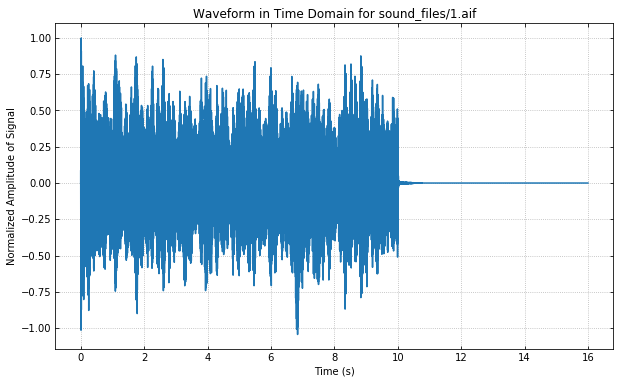

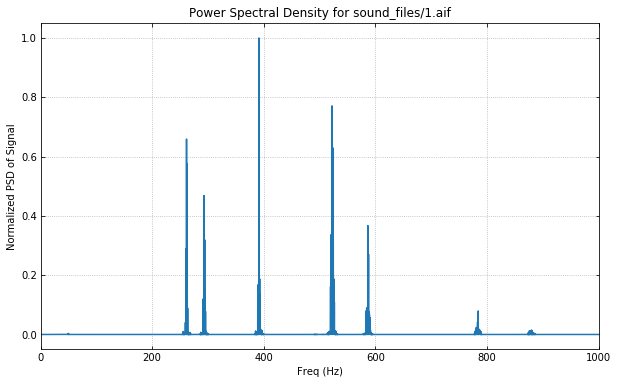

In [550]:
soundFileTest = "sound_files/1.aif"
# open the sound file
with aifc.open(soundFileTest) as af:
    nFrames = af.getnframes() # get number of frames
    sampleRate = af.getframerate() # get samplerate
    strSig = af.readframes(nFrames) # given the number of frames, read them out
    signal2 = np.fromstring(strSig, dtype=np.int32).byteswap() # convert to np array for analysis

# periodogram amounts to taking the magnitude of the fft, squaring it, and taking only the positive frequencies
# this gives us the power spectral density
freqs2,pSignal2 = periodogram(signal2,fs=sampleRate)

# plot the waveform in time domain
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(signal2)/sampleRate,1/sampleRate),signal2/max(signal2))
plt.ylabel("Normalized Amplitude of Signal")
plt.xlabel("Time (s)")
plt.tick_params(which="both",direction="in",right="on",top="on")
plt.grid(linestyle="dotted")
plt.title(f"Waveform in Time Domain for {soundFile}");

# plot the PSD of the waveform
plt.figure(figsize=(10,6))
plt.plot(freqs2,pSignal2/max(pSignal2))
plt.ylabel("Normalized PSD of Signal")
plt.xlabel("Freq (Hz)")
plt.xlim((0,1000)) # let's zoom to under 1 kHz
plt.tick_params(which="both",direction="in",right="on",top="on")
plt.grid(linestyle="dotted")
plt.title(f"Power Spectral Density for {soundFile}");

For this file, peaks at ~261.63 Hz (C4), ~293.66(D4), and ~392.00 (G4) were detected. We can see them here, as well as their first harmonics!